![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Captioning with an Encoder-Decoder RNN

This notebook demonstrates how to build an image captioning model using a classic encoder-decoder architecture. This is a fascinating multi-modal task that combines Computer Vision (to understand the image) and Natural Language Processing (to generate a descriptive sentence).

### **📌 The Core Idea: Encoder-Decoder**
The model consists of two main parts that work together:

1.  **The Encoder**: A pre-trained Convolutional Neural Network (CNN), like ResNet, acts as the encoder. It takes an image as input and outputs a compact feature vector (an embedding). This vector is a rich, numerical representation of the image's content—its "thought" vector.

2.  **The Decoder**: A Recurrent Neural Network (RNN), specifically an LSTM in our case, acts as the decoder. It takes the image's feature vector from the encoder and generates the caption one word at a time. It learns the statistical structure of language to produce coherent sentences.

In [1]:
from IPython.display import display

In [2]:
# %pip install torch torchvision pillow spacy numpy
# %pip install torchtext
# %pip install pycocotools

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import random
from tqdm import tqdm
import kagglehub
import pandas as pd
from PIL import Image
import spacy
from IPython.display import display
import pickle
import os
import matplotlib.pyplot as plt

## 1️⃣ The Dataset: Flickr8k
We will use the Flickr8k dataset, a popular benchmark for image captioning. It contains:
- **8,000 Images**: Sourced from the Flickr website.
- **40,000 Captions**: Each image is paired with five different human-generated captions, providing a rich variety of descriptions.

First, we'll download the dataset from Kaggle Hub and inspect its contents.

In [4]:
# Download the Flickr8k dataset
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [5]:
# Load the captions from the `captions.txt` file
captions_path = os.path.join(path, "captions.txt")
captions_df = pd.read_csv(captions_path)
print(f"Captions loaded: {len(captions_df)} entries")
print(captions_df.head())

Captions loaded: 40455 entries
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [6]:
# Images directory
images_dir = os.path.join(path, "Images")
print(f"Images directory: {images_dir}")
print(f"Number of images: {len(os.listdir(images_dir))}")

Images directory: /kaggle/input/flickr8k/Images
Number of images: 8091


Sample caption: A child in a pink dress is climbing up a set of stairs in an entry way .


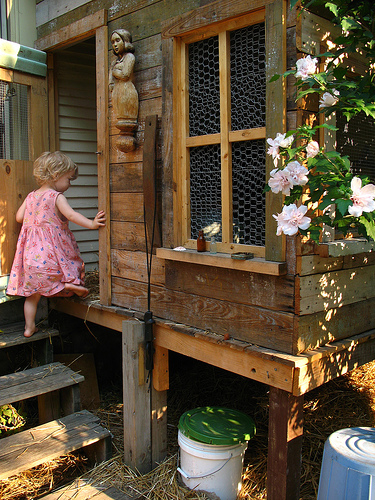

In [7]:
# Let's look at a sample image and one of its captions
print("Sample caption:", captions_df.iloc[0]['caption'])
sample_image_path = os.path.join(images_dir, captions_df.iloc[0]['image'])
sample_img = Image.open(sample_image_path)
display(sample_img)

## 2️⃣ Building the Vocabulary

Neural networks work with numbers, not words. Therefore, we need to build a **vocabulary** to map every unique word in our dataset to a unique integer index. We also add special tokens that are crucial for the training process:

- `<PAD>`: A padding token used to make all sequences in a batch the same length.
- `<SOS>`: A "Start of Sentence" token that signals the beginning of a caption to the decoder.
- `<EOS>`: An "End of Sentence" token that the model learns to predict when it has finished generating a caption.
- `<UNK>`: An "Unknown" token for words that appear in the test set but not in our training vocabulary.

We use the `spaCy` library for robust and efficient tokenization.

In [29]:
spacy_eng = spacy.load("en_core_web_sm") # you might need to run this: python -m spacy download en_core_web_sm

In [9]:
def word_tokenize(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

In [10]:
# Initialize vocabulary with special tokens
word_to_index = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
index_to_word = {idx: word for word, idx in word_to_index.items()}
word_freq = {}

# Build vocabulary from all captions in the dataset
for caption in tqdm(captions_df['caption']):
    tokens = word_tokenize(caption.lower())

    for token in tokens:
        if token not in word_to_index:
            idx = len(word_to_index)
            word_to_index[token] = idx
            index_to_word[idx] = token
            word_freq[token] = 1
        else:
            word_freq[token] += 1

print(f"\nVocabulary size: {len(word_to_index)}")

100%|██████████| 40455/40455 [00:01<00:00, 36065.90it/s]


Vocabulary size: 8508


In [11]:
word_tokenize('<SOS> hi, my friend <EOS>')  # We will manually add tokens for <EOS> and <SOS> etc after tokenization to avoid them breaking up.

['<', 'sos', '>', 'hi', ',', 'my', 'friend', '<', 'eos', '>']

## 3️⃣ The Model: A CNN-RNN Encoder-Decoder
Our model is composed of two main modules: an Encoder to process the image and a Decoder to generate the text.

### 🔹 The Encoder (CNN)
We use a pre-trained ResNet-50 model, which has already learned rich feature representations from the large ImageNet dataset. We perform two key modifications:
1.  **Freeze Layers**: We freeze all the convolutional layers (`requires_grad_(False)`) to prevent them from being updated during training. This is a form of transfer learning that speeds up training and prevents overfitting.
2.  **Replace Classifier**: We chop off the final, fully-connected classification layer (which originally predicts 1000 ImageNet classes) and replace it with a new `nn.Linear` layer. This new layer will output a feature vector of `embed_size`, which will be the input to our decoder.

### 🔹 The Decoder (RNN)
The decoder is an LSTM (Long Short-Term Memory) network, a type of RNN well-suited for sequence generation.

1.  **Embedding Layer**: It first converts the integer-coded words of the caption into dense vectors of size `embed_size`.
2.  **Input Concatenation**: The decoder's first input is the image feature vector from the encoder. For subsequent steps, it takes the embedded representation of the previously generated word.
3.  **LSTM**: The LSTM processes the sequence of inputs, maintaining a hidden state that keeps track of the context of the generated sentence.
4.  **Linear Layer**: A final linear layer maps the LSTM's output to the size of our vocabulary, producing a probability distribution over all possible next words.

### 🔹 The Inference Method (`caption_image`)
This method is used for generating new captions after the model is trained. It works *autoregressively*:
1.  The image is passed through the encoder to get its feature vector.
2.  This feature vector is fed into the decoder to predict the first word (which should be `<SOS>`).
3.  The predicted word is then fed back into the decoder as input for the next time step.
4.  This process repeats until the model predicts the `<EOS>` token or a maximum length is reached.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        # Use a pretrained ResNet-50 and freeze its parameters
        self.resnet = models.resnet50(weights='IMAGENET1K_V1').requires_grad_(False)
        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM is chosen as the RNN architecture
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.Linear(1024, vocab_size)
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        # Embed the captions and apply dropout
        embeddings = self.dropout(self.embed(captions))
        # Concatenate image features and caption embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, _ = self.rnn(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class ImageCaptioner(nn.Module):
    """A wrapper model combining the Encoder and Decoder."""
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptioner, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, max_length=50):
        """Autoregressive caption generation for inference."""
        result_caption = []

        with torch.no_grad():
            x = self.encoder(image).unsqueeze(1)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoder.rnn(x, states)
                output = self.decoder.linear(hiddens.squeeze(1))
                predicted_idx = output.argmax(1)
                # .argmax(): This is a PyTorch (or NumPy/TensorFlow) method that returns the indices of the maximum values along a specified dimension.
                # (1): This argument specifies the dimension along which the argmax operation should be performed. In this case, 1 refers to the second dimension (0-indexed).

                predicted_token = index_to_word.get(predicted_idx.item())
                if predicted_token is None: # Should not happen
                    break

                result_caption.append(predicted_token)

                # Prepare the next input
                x = self.decoder.embed(predicted_idx).unsqueeze(1)

                if predicted_token == "<EOS>":
                    break

        return result_caption

## 4️⃣ The PyTorch Dataset and DataLoader
We create a custom `Flickr8kDataset` class to interface with our data. This is the standard PyTorch way to prepare data for a `DataLoader`.

The `__getitem__` method is the most important part. For a given index `idx`, it performs these steps:
1.  Loads the image and its corresponding caption from our dataframe.
2.  Applies the necessary image transformations (resizing to a fixed size, converting to a tensor, and normalizing).
3.  Tokenizes the caption, converts it to a sequence of indices, and adds the `<SOS>` and `<EOS>` tokens.
4.  Pads the caption tensor with the `<PAD>` token index so that all sequences in a batch have the same length (`max_seq_len`). This is required for batch processing.

In [13]:
def convert_sentence_to_idxs(sentence):
    words = word_tokenize(sentence)
    idxs = [word_to_index.get(word, word_to_index['<UNK>']) for word in words]
    return idxs

def convert_idxs_to_sentence(idxs):
    words = [index_to_word[idx] for idx in idxs]
    return ' '.join(words)

class Flickr8kDataset(Dataset):
    def __init__(self, captions_df, images_dir, max_seq_len, transform):
        self.captions_df = captions_df
        self.images_dir = images_dir
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        row = self.captions_df.iloc[idx]

        # Load image
        img_path = os.path.join(self.images_dir, row['image'])
        img = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        # Process caption
        caption = row['caption'].lower().strip()
        caption_idxs = convert_sentence_to_idxs(caption)

        # Truncate if caption is too long
        if len(caption_idxs) > self.max_seq_len - 2:  # 2 for SOS and EOS
            caption_idxs = caption_idxs[:self.max_seq_len-2]

        # Calculate padding length
        padding_len = self.max_seq_len - len(caption_idxs) - 2

        # Create the final tensor with special tokens and padding
        caption_tensor = (
            [word_to_index['<SOS>']] +
            caption_idxs +
            [word_to_index['<EOS>']] +
            [word_to_index['<PAD>']] * padding_len
        )

        caption_tensor = torch.tensor(caption_tensor, dtype=torch.long)
        return img, caption_tensor

In [14]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet stats
])

# For demonstration purposes, we'll train on a small subset of the data.
# Increase this for better results!
train_size = min(5000, len(captions_df))
train_captions = captions_df.head(train_size)

batch_size = 32
max_seq_len = 50 # Max caption length

train_dataset = Flickr8kDataset(train_captions, images_dir, max_seq_len=max_seq_len, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Training on {len(train_dataset)} image-caption pairs")

Training on 5000 image-caption pairs


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 5️⃣ Model Training
Now we define the hyperparameters, initialize the model, and set up the optimizer and loss function for training.

### 🔹 Hyperparameters & Setup
These are the key settings for our model and training process. Tuning these can significantly impact performance.

In [16]:
embed_size = 512
hidden_size = 256
vocab_size = len(word_to_index)
num_decoder_layers = 3
learning_rate = 1e-4
num_epochs = 15 # Increased for better results, but still short for a full training

### 🔹 Loss Function and Optimizer
- **Loss Function**: We use `nn.CrossEntropyLoss`. This is the standard choice for multi-class classification, which is what we're doing at each time step—predicting the next word from the entire vocabulary.
Importantly, we set `ignore_index=word_to_index['<PAD>']`. This tells the loss function to ignore the `<PAD>` tokens when calculating the loss, so the model isn't penalized for its predictions on padded parts of the sequence.

- **Optimizer**: We use the Adam optimizer, a popular and effective choice for deep learning models.

In [17]:
# Initialize model, loss, and optimizer
model = ImageCaptioner(embed_size, hidden_size, vocab_size, num_decoder_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the final layer of the CNN encoder
for name, param in model.encoder.resnet.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [18]:
print(f"Vocabulary size: {len(word_to_index)}")
print(f"Sample vocabulary: {list(word_to_index.keys())[:20]}")

Vocabulary size: 8508
Sample vocabulary: ['<PAD>', '<SOS>', '<EOS>', '<UNK>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'entry', 'way', '.', 'girl']


In [19]:
print(f"SOS token: {word_to_index['<SOS>']}")
print(f"EOS token: {word_to_index['<EOS>']}")
print(f"PAD token: {word_to_index['<PAD>']}")
print(f"UNK token: {word_to_index['<UNK>']}")

SOS token: 1
EOS token: 2
PAD token: 0
UNK token: 3


### 🔹 Pre-training Check
Before we start training, let's see what our randomly initialized model produces. We expect the captions to be nonsensical.

In [20]:
# Prepare a few random test samples
test_samples = []
test_images = []

random_indices = random.sample(range(len(captions_df)), min(3, len(captions_df)))

for i in random_indices:
    row = captions_df.iloc[i]
    img_path = os.path.join(images_dir, row['image'])
    img = Image.open(img_path).convert('RGB')

    test_samples.append({'image': img, 'caption': row['caption']})
    img_tensor = transform(img).to(device)
    test_images.append(img_tensor)

--- Pre-training captions ---


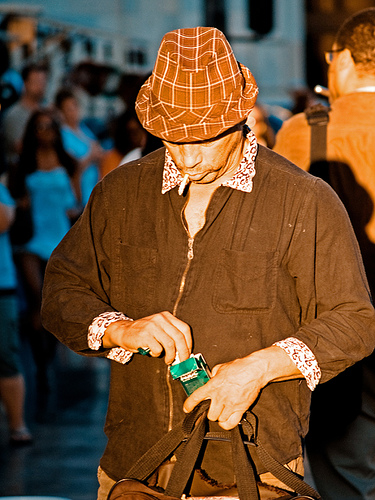

Generated: drawn coffee coffee coffee m m coffee coffee m chains m coffee m chains coffee m m mad coffee coffee coffee m chains coffee glacier m mad coffee coffee coffee m coffee chains m coffee chains glacier glacier glacier glacier mad coffee coffee coffee coffee m coffee m coffee chains
Original: A man in an orange hat pulls a cigarette out of a box .
--------------------------------------------------


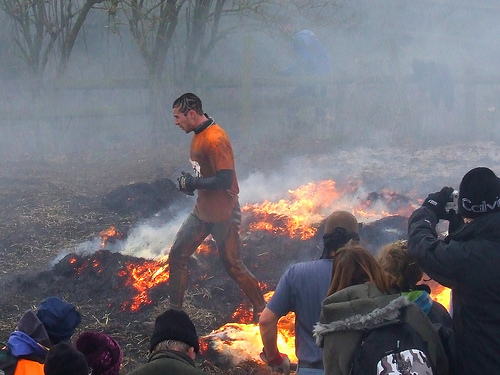

Generated: drawn coffee coffee coffee m m coffee m chains coffee m m mad coffee coffee coffee chains m glacier glacier glacier mad coffee coffee coffee coffee m coffee m coffee chains m chains glacier glacier glacier glacier mad coffee coffee coffee coffee m coffee m coffee chains m coffee m
Original: A man is walking through fire .
--------------------------------------------------


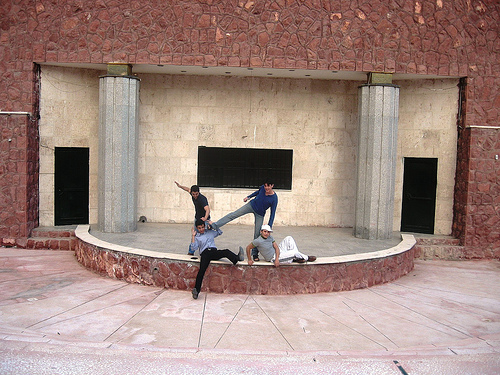

Generated: drawn coffee coffee coffee m m coffee coffee m chains m coffee m chains coffee m m mad coffee coffee coffee m chains coffee glacier m mad coffee coffee coffee m coffee chains m coffee chains glacier glacier glacier glacier mad coffee coffee coffee coffee m coffee m coffee chains
Original: Four guys in front of a abandoned building trying to make a letter with their bodies
--------------------------------------------------


In [21]:
print("--- Pre-training captions ---")
model.eval()
for i, sample in enumerate(test_samples):
    display(sample['image'])

    with torch.no_grad():
        # The model's `caption_image` expects a batch, so we add a dimension with unsqueeze(0)
        caption = model.caption_image(test_images[i].unsqueeze(0))
        caption_text = ' '.join(caption)
        print(f"Generated: {caption_text}")
        print(f"Original: {sample['caption']}")
        print("-" * 50)

### 🔹 The Training Loop
The training process involves iterating through the dataset for a number of epochs. In each step:

1.  **Teacher Forcing**: We feed the ground-truth caption (shifted by one position) into the decoder at each time step, regardless of the decoder's own prediction from the previous step. This is a technique called *teacher forcing*, which stabilizes training and helps the model learn the language structure more quickly. We feed `captions[:, :-1]` (from `<SOS>` to the second-to-last word) and expect the model to predict `captions[:, 1:]` (from the first word to `<EOS>`).
2.  **Calculate Loss**: The model's output (logits) is compared against the target sequence to calculate the loss.
3.  **Backpropagation**: The loss is backpropagated through the network to compute gradients.
4.  **Gradient Clipping**: We clip the gradients (`clip_grad_norm_`) to a maximum value. This is a common practice in RNN training to prevent the "exploding gradients" problem.
5.  **Optimizer Step**: The optimizer updates the model's trainable parameters (the decoder and the final layer of the encoder).

In [22]:
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False,
        desc=f"Epoch {epoch+1}/{num_epochs}"
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        # Teacher forcing: feed the ground-truth captions (shifted) to the decoder
        outputs = model(imgs, captions[:, :-1])

        # We skip the first prediction, which corresponds to the image feature input.
        outputs = outputs[:, 1:, :]
        targets = captions[:, 1:]

        # Reshape for CrossEntropyLoss and calculate loss
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]),  # Shape: [batch_size * (seq_len-1), vocab_size]
            targets.flatten()                       # Shape: [batch_size * (seq_len-1)]
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss) # Save loss for plotting
    print(f'Epoch: {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    # Test generation every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        print(f"\n--- Testing after epoch {epoch+1} ---")
        with torch.no_grad():
            test_caption = model.caption_image(test_images[0].unsqueeze(0))
            print(f"Generated: {' '.join(test_caption)}")
            print(f"Original: {test_samples[0]['caption']}")
        print("-" * 50)

Epoch: 1/15, Average Loss: 6.1454


Epoch: 2/15, Average Loss: 4.8191


Epoch: 3/15, Average Loss: 4.4269


Epoch: 4/15, Average Loss: 4.1955


Epoch: 5/15, Average Loss: 4.0098

--- Testing after epoch 5 ---
Generated: a man is is is is is and a white dog is and a black dog is and a black dog in a field . <EOS>
Original: A man in an orange hat pulls a cigarette out of a box .
--------------------------------------------------


Epoch: 6/15, Average Loss: 3.8646


Epoch: 7/15, Average Loss: 3.7670


Epoch: 8/15, Average Loss: 3.6950


Epoch: 9/15, Average Loss: 3.6330


Epoch: 10/15, Average Loss: 3.5840

--- Testing after epoch 10 ---
Generated: a man in a red shirt is jumping on a field . <EOS>
Original: A man in an orange hat pulls a cigarette out of a box .
--------------------------------------------------


Epoch: 11/15, Average Loss: 3.5293


Epoch: 12/15, Average Loss: 3.4880


Epoch: 13/15, Average Loss: 3.4402


Epoch: 14/15, Average Loss: 3.3884


Epoch: 15/15, Average Loss: 3.3400

--- Testing after epoch 15 ---
Generated: a man in a white shirt is standing on a green field . <EOS>
Original: A man in an orange hat pulls a cigarette out of a box .
--------------------------------------------------


### 🔹 Plotting the Training Progress
Visualizing the loss helps us understand how well the model is learning. A decreasing loss indicates that the model is successfully minimizing its prediction error over time.

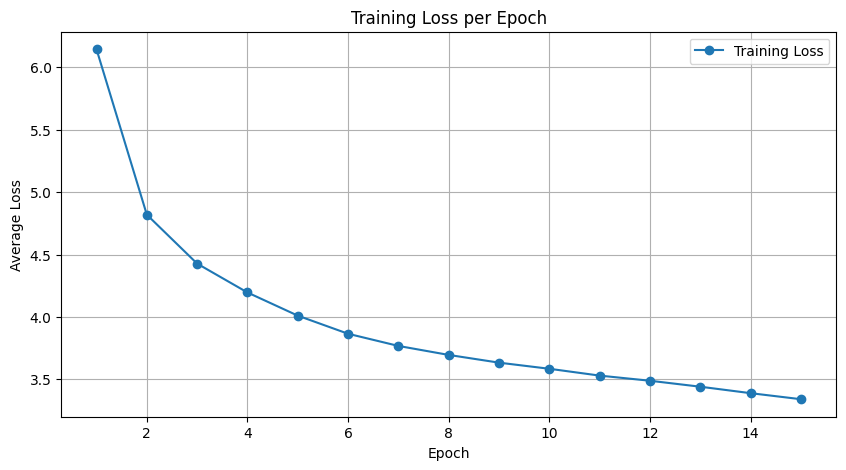

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'o-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

## 6️⃣ Saving and Loading the Model

To avoid retraining the model every time we want to use it, we can save its state. It's good practice to save three things:
1.  **Model State Dictionary**: The learned weights and biases of the model.
2.  **Vocabulary Mappings**: The `word_to_index` and `index_to_word` dictionaries are essential for converting between words and indices during inference.
3.  **Model Configuration**: The hyperparameters used to build the model (`embed_size`, `hidden_size`, etc.), so we can perfectly reconstruct the architecture before loading the weights.

In [24]:
def save_model(model, word_to_index, index_to_word, model_config, save_dir="flickr8k_rnn_image_captioning_dataset"):
    """
    Save the trained model, vocabulary, and configuration to a specified directory.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model state dict
    model_path = os.path.join(save_dir, 'flickr8k_image_captioner.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model state dict saved to '{model_path}'")

    # Save vocabulary mappings
    vocab_data = {
        'word_to_index': word_to_index,
        'index_to_word': index_to_word,
        'vocab_size': len(word_to_index)
    }
    vocab_path = os.path.join(save_dir, 'vocab_mappings.pkl')
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab_data, f)
    print(f"Vocabulary mappings saved to '{vocab_path}'")

    # Save model configuration
    config_path = os.path.join(save_dir, 'model_config.pkl')
    with open(config_path, 'wb') as f:
        pickle.dump(model_config, f)
    print(f"Model configuration saved to '{config_path}'")

    print(f"\nAll files saved successfully in '{save_dir}' directory!")

In [25]:
# Define the model configuration to be saved
model_config = {
    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'vocab_size': vocab_size,
    'num_decoder_layers': num_decoder_layers
}

# Save the current trained model
save_model(model, word_to_index, index_to_word, model_config)

Model state dict saved to 'flickr8k_rnn_image_captioning_dataset/flickr8k_image_captioner.pth'
Vocabulary mappings saved to 'flickr8k_rnn_image_captioning_dataset/vocab_mappings.pkl'
Model configuration saved to 'flickr8k_rnn_image_captioning_dataset/model_config.pkl'

All files saved successfully in 'flickr8k_rnn_image_captioning_dataset' directory!


In [26]:
def load_model(save_dir="flickr8k_rnn_image_captioning_dataset", device='cpu'):
    """
    Load the trained model, vocabulary, and configuration from a specified directory.
    """
    # Load vocabulary mappings
    vocab_path = os.path.join(save_dir, 'vocab_mappings.pkl')
    with open(vocab_path, 'rb') as f:
        vocab_data = pickle.load(f)
    print(f"Vocabulary mappings loaded from '{vocab_path}'")

    # Load model configuration
    config_path = os.path.join(save_dir, 'model_config.pkl')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    print(f"Model configuration loaded from '{config_path}'")

    # Recreate model architecture using the loaded config
    model = ImageCaptioner(
        config['embed_size'],
        config['hidden_size'],
        config['vocab_size'],
        config['num_decoder_layers']
    )

    # Load model weights
    model_path = os.path.join(save_dir, 'flickr8k_image_captioner.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Set model to evaluation mode
    print(f"Model weights loaded from '{model_path}'")

    print(f"\nModel loaded successfully from '{save_dir}' directory!")
    return model, vocab_data['word_to_index'], vocab_data['index_to_word']

In [27]:
# Example of loading the model
# We also reload the vocabulary to ensure consistency, especially if running this section independently
loaded_model, word_to_index_loaded, index_to_word_loaded = load_model(device=device)

Vocabulary mappings loaded from 'flickr8k_rnn_image_captioning_dataset/vocab_mappings.pkl'
Model configuration loaded from 'flickr8k_rnn_image_captioning_dataset/model_config.pkl'
Model weights loaded from 'flickr8k_rnn_image_captioning_dataset/flickr8k_image_captioner.pth'

Model loaded successfully from 'flickr8k_rnn_image_captioning_dataset' directory!


## 7️⃣ Generating Captions (Inference)
Finally, let's see our trained model in action! We will use the same test images from our pre-training check and compare the new, hopefully much-improved, captions.

The model is set to evaluation mode (`model.eval()`) to disable layers like Dropout that are only used during training.


--- Post-training captions ---


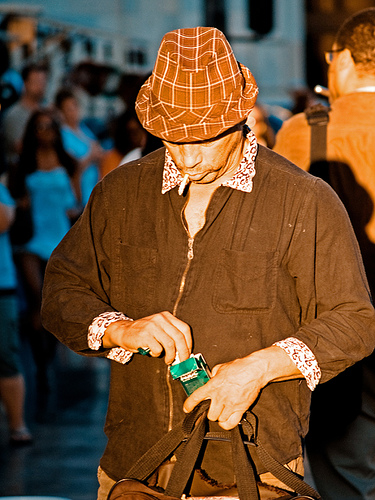

Image 1:
  Generated: a man in a white shirt is standing on a green field . <EOS>
  Original:  A man in an orange hat pulls a cigarette out of a box .
--------------------------------------------------


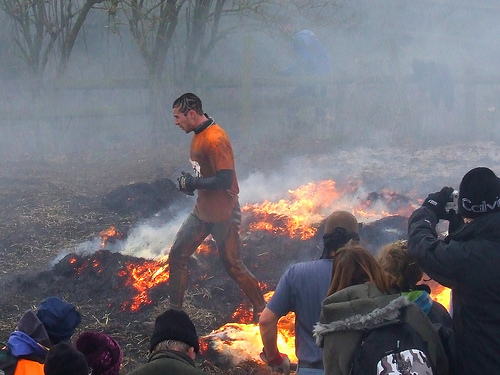

Image 2:
  Generated: a man in a blue shirt is running through the grass . <EOS>
  Original:  A man is walking through fire .
--------------------------------------------------


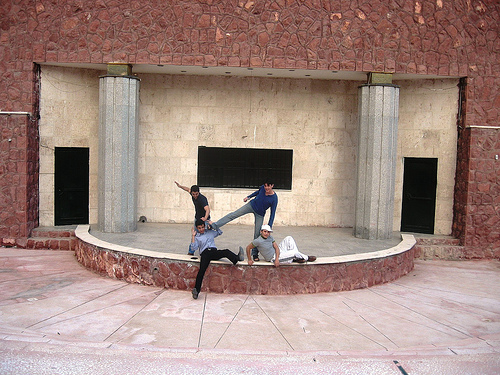

Image 3:
  Generated: a man in a white shirt is running through the grass . <EOS>
  Original:  Four guys in front of a abandoned building trying to make a letter with their bodies
--------------------------------------------------


In [28]:
model.eval() # Ensure model is in evaluation mode

print("\n--- Post-training captions ---")

for i, sample in enumerate(test_samples):
    display(sample['image'])

    with torch.no_grad():
        caption = model.caption_image(test_images[i].unsqueeze(0))
        caption_text = ' '.join(caption)
        print(f"Image {i+1}:")
        print(f"  Generated: {caption_text}")
        print(f"  Original:  {sample['caption']}")
        print("-" * 50)

## 8️⃣ Conclusion & Next Steps

We have successfully built, trained, and evaluated an image captioning model using a CNN encoder and an RNN decoder. While the results after a short training run are promising, they can be significantly improved.

### **📝 Exercises for Further Exploration**
1.  **More Training**: The most impactful change would be to train for more `epochs` on a larger portion of the dataset (or the full dataset). Deep learning models are data-hungry!
2.  **Hyperparameter Tuning**: Experiment with different values for `embed_size`, `hidden_size`, `num_decoder_layers`, and `learning_rate`.
3.  **Different RNNs**: Replace the `nn.LSTM` with a `nn.GRU` in the decoder. Compare the results and training time.
4.  **Attention Mechanism**: The biggest architectural improvement for this task is to add an **attention mechanism**. Attention allows the decoder to dynamically focus on different parts of the image as it generates each word, often leading to more accurate and contextually relevant captions. This is a key component in modern sequence-to-sequence models.
5.  **Beam Search Decoding**: The current `caption_image` method uses greedy decoding (picking the single best word at each step). Implement **beam search**, which keeps track of the `k` most probable sequences at each step, often resulting in higher-quality final captions.

### Contributed by: Ali Habibullah(Changed from Telha Bilal original notebook 🫡)